<p align="center">
  <span style="color:#C64A44; font-size:24px;"><b>A/B Testing with ANOVA (Analysis of Variance)</b></span>
</p>

<b>Table of Contents</b><br>
* [Basic Stats](#1)
* [Normality and Normality Test](#2)
* [Define Hypotheses](#3)
* [Kruskal-Wallis Test](#4)
* [Conclusion](#5)

In [4]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
from scipy.stats import shapiro, kruskal
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f'% x)

In [5]:
df = pd.read_csv('WA_Marketing-Campaign.csv')

<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color:#C64A44; font-size: 20px; font-weight: bold;", id=1>Basic Stats</h1>
</div>

<b><u>Columns</u></b><br>

**MarketID:** the unique identifier of the campaign  
**MarketSize:** size of the market by sales. Has 3 unique values: large, medium, and small  
**LocationID:** the unique identifier of the store location  
**AgeOfStore:** the age of store in years. Max age is 28 years and min age is 1 year old.  
**Promotion:** Contains 3 unique values: 1, 2, and 3  
**week:** one of four weeks when the promotions were run  
**SalesInThousands:** sales amount for a specific LocationID, Promotion, and week  

In [20]:
#examine the basic info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [7]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.7300
1,1,Medium,1,4,3,2,35.6700
2,1,Medium,1,4,3,3,29.0300
3,1,Medium,1,4,3,4,39.2500
4,1,Medium,2,5,2,1,27.8100


In [8]:
df.sample(5)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
458,9,Medium,808,20,3,3,60.9700
38,1,Medium,10,5,2,3,23.9300
480,10,Large,904,10,2,1,51.0900
157,3,Large,221,23,2,2,74.0300
264,6,Medium,502,19,2,1,31.9400


In [9]:
#further examine specific columns
for index, col in enumerate(df.columns):
    if index in (1,4,5,7):
        print(col)
        display(pd.DataFrame(df[col].value_counts()).reset_index())

MarketSize


,MarketSize,count
0,Medium,320
1,Large,168
2,Small,60


Promotion


,Promotion,count
0,3,188
1,2,188
2,1,172


week


,week,count
0,1,137
1,2,137
2,3,137
3,4,137


In [10]:
#get the quantiles of relevant columns and transpose the result for better readibility
df.describe([0.05, 0.10, 0.25, 0.50, 0.75]).T.iloc[2:, :]

,count,mean,std,min,5%,10%,25%,50%,75%,max
AgeOfStore,548.0000,8.5036,6.6383,1.0000,1.0000,1.0000,4.0000,7.0000,12.0000,28.0000
Promotion,548.0000,2.0292,0.8107,1.0000,1.0000,1.0000,1.0000,2.0000,3.0000,3.0000
week,548.0000,2.5000,1.1191,1.0000,1.0000,1.0000,1.7500,2.5000,3.2500,4.0000
SalesInThousands,548.0000,53.4662,16.7552,17.3400,30.6215,35.4120,42.5450,50.2000,60.4775,99.6500


In [11]:
df.groupby(['MarketSize','Promotion']).agg({'SalesInThousands':['sum','mean']})

SalesInThousands        
                                  sum    mean
MarketSize Promotion                         
Large      1                4213.2100 75.2359
           2                3860.6100 60.3220
           3                3705.7900 77.2040
Medium     1                4576.5700 47.6726
           2                4224.3500 39.1144
           3                5274.3900 45.4689
Small      1                1203.2500 60.1625
           2                 812.9700 50.8106
           3                1428.3400 59.5142

<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color:#C64A44; font-size: 20px; font-weight: bold;", id=2>Normality and Normality Test</h1>
</div>

This project will test the normality of the data both visually and statistically.

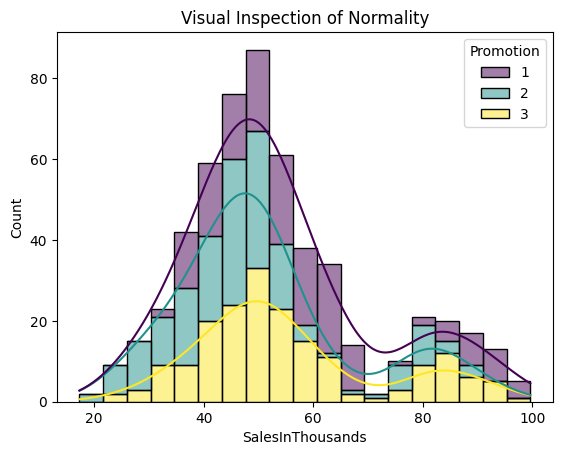

In [15]:
#We start with visual inspection on the normality of the dataset.
sns.histplot(df, x = 'SalesInThousands', hue = 'Promotion', multiple = 'stack', palette = 'viridis', kde = True)
plt.title('Visual Inspection of Normality')
plt.show()

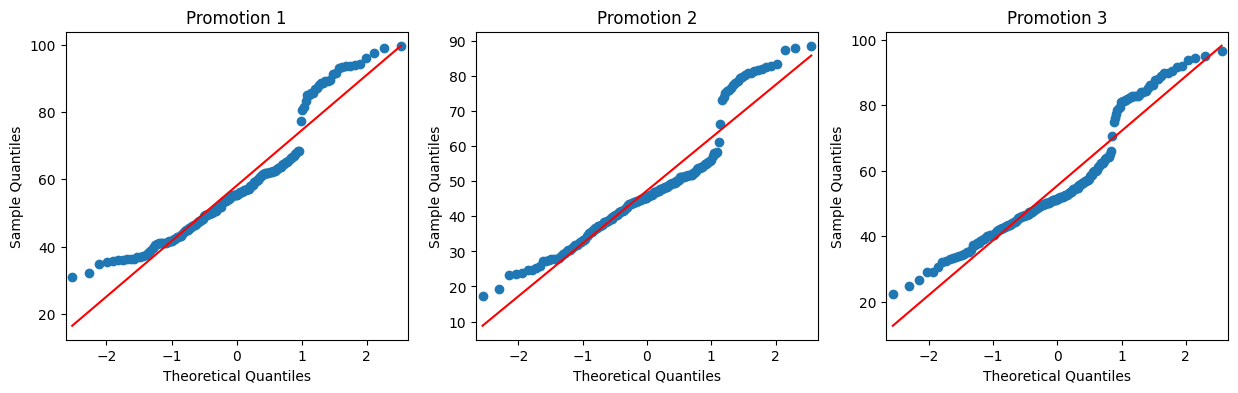

In [16]:
#further examine normality with qqplots
fig, axes = plt.subplots(1, 3, figsize = (15, 4))
sm.qqplot(df.loc[df['Promotion']==1, 'SalesInThousands'], line = 's', ax = axes[0])
sm.qqplot(df.loc[df['Promotion']==2, 'SalesInThousands'], line = 's', ax = axes[1])
sm.qqplot(df.loc[df['Promotion']==3, 'SalesInThousands'], line = 's', ax = axes[2])

axes[0].set_title('Promotion 1')
axes[1].set_title('Promotion 2')
axes[2].set_title('Promotion 3')
plt.show()

According to the plots above, the data does not appear to be normally distributed. All 3 qqplots indicate that there are more data at large values and less data at small values. None of the promotions contain any extreme values.

The qqplots also reveal that the distribution of all 3 promotions have a fat tail on the right and a thin tail on the left, which matches the pattern revealed by the histogram.

In [17]:
#Analytical testing with Shapiro-Wilk Test
alpha = 0.05
for i in range(1, 4):
    stats, p_value = shapiro(df.loc[df['Promotion']==i, 'SalesInThousands'])
    if p_value > alpha:
        print(f'Promotion {i}: With p_value of {p_value}, we can conclude with 95% confidence that the data is normally distributed')
    else:
        print(f'Promotion {i}: With p_value of {p_value}, we can conclude with 95% confidence that the data is NOT normally distributed')

Promotion 1: With p_value of 1.9772645044477294e-08, we can conclude with 95% confidence that the data is NOT normally distributed
Promotion 2: With p_value of 5.457099666274281e-09, we can conclude with 95% confidence that the data is NOT normally distributed
Promotion 3: With p_value of 1.49946592611918e-08, we can conclude with 95% confidence that the data is NOT normally distributed


<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color:#C64A44; font-size: 20px; font-weight: bold;", id=3>Define Hypotheses</h1>
</div>

**Null Hypothesis (H0):**  
M1 = M2 = M3  
There is no statistically significant difference between sales from the promotions.  

**Alternative Hypothesis (H1):**    
There is a statistically significant difference between the sales of at least two promotions.

Significance Level = 0.05

<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color:#C64A44; font-size: 20px; font-weight: bold;", id=4>Kruskal-Wallis Test
</h1>
</div>

Since the data does not follow a normal distribution, we will need to opt for a non-parametric test.

In [18]:
promo_1 = df.loc[df['Promotion']==1, 'SalesInThousands']
promo_2 = df.loc[df['Promotion']==2, 'SalesInThousands']
promo_3 = df.loc[df['Promotion']==3, 'SalesInThousands']

statistics, p_value = kruskal(promo_1, promo_2, promo_3)

In [19]:
print(statistics, p_value)

53.29475169322799 2.6741866266697816e-12


<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color:#C64A44; font-size: 20px; font-weight: bold;", id=5>Conclusion
</h1>
</div>

The p-value is much smaller than the significance level of 0.05, which means that the probability of observing data as extreme as the one calculated if the null hypothesis is true is extremely low. Therefore, we can reject the null hypothesis and accept the alternative hypothesis and conclude that there are significant difference in medians among the groups of promotions.